# Ensemble Learning
我们可以将不同分类器组合，这种组合结果被称为Ensemble Method 或者 meta-algorithm，这种集成通常有多种形式
- 不同算法集成
- 同一算法不同设置下的集成
- 数据集不同部分分给不同分类器

## bagging
- 基于数据随机重抽样的分类器构建方法，也叫作Bootstrap aggregating，指从原始数据集选择S次后得到S个新的数据集的一种技术。
- 新数据集和原始数据集大小相等，每个数据集都通过在原始数据集中随机选择一个样本替换获得，可以多次选择同一样本
- S个数据集建好之后，将某个学习算法分别用于每个数据集，获得S个分类器，分类时则用这S个分类器进行分类，选择分类器投票结果中类别最多的作为最终分类结果

## boosting
- 与bagging技术很类似，但bagging中多个分类器并行获得。boosting的不同分类器则是串行获得，每个新的分类器根据已经训练出的分类器性能进行训练。boosting通过几种关注被错误分类的数据构建新分类器
- boosting分类结果是基于所有分类器加权求和的结果，bagging中多个分类器的权重不相等，每个权重代表其对应分类器在上一轮迭代中的成功度



# AdaBoost
- 优点: 泛化错误率地，易于编码，可以应用在大部分分类器上，无参数调整
- 缺点: 对离群点
- 使用数据类型：数值型和标称型数据

**一般流程**
1. 收集数据
2. 准备数据：依赖于所使用弱分类器类型，作为弱分类器，简单分类器效果更好
3. 分析数据
4. 训练算法: 分类器多次在统一数据集上训练弱分类器
5. 测试算法
6. 使用算法：通SVM一样AdaBoost是做二分类的，如果想应用于多分类，需要通svm一样做出相应的扩展

**基于错误提升分类器性能**
- AdaBoost是adaptive boosting缩写，训练数据中的每个样本都会被赋予一个权重组成权重向量D，初始时权重都初始化为等值
- 先在弱分类器训练计算对应的错误率，然后在同一数据集上在此训练弱分类器，第二次训练过程中会调整每个样本的权重，第一次分类对的样本权重会降低，分类错的权重会提高
- 为了从所有弱分类器中获得最终分类结果，AdaBoost为每个分类器分配了一个权重值alpha，这些alpha是基于每个弱分类器的错误率进行计算的，其中错误率定义为
$$
\varepsilon = \frac{未正确分类样本数}{所有样本数}\\
\alpha = \frac12 ln(\frac{1-\varepsilon}\varepsilon)
$$
- 获得alpha后，可以对权重向量D进行更新，使得正确分类的样本权重降低而错分样本权重升高，D的计算方法如下
$$
正确样本：D^{t+1}_t = \frac{D^t_i e^{-\alpha}}{sum(D)}\\
错误样本：D^{t+1}_t = \frac{D^t_i e^{\alpha}}{sum(D)}
$$
- 随后不断迭代，直到到达用户指定值

## 单层决策树构建弱分类器
仅基于单个特征来做决策

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def loadSimpData():
    dataMat = np.matrix([[ 1. ,  2.1],
            [ 2.0,  1.1],
            [ 1.3,  1.0 ],
            [ 1. ,  1. ],
            [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return dataMat,classLabels

In [2]:
dataMat,classLabels = loadSimpData()
dataMat

matrix([[1. , 2.1],
        [2. , 1.1],
        [1.3, 1. ],
        [1. , 1. ],
        [2. , 1. ]])

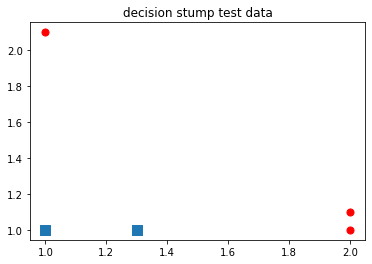

In [3]:
# 数据可视化
def datashow(dataMat,classLabels):
    xcord0 = []
    ycord0 = []
    xcord1 = []
    ycord1 = []
    markers =[]
    colors =[]

    for i in range(len(classLabels)):
        i
        if classLabels[i]==1.0:
            xcord1.append(dataMat[i,0])
            ycord1.append(dataMat[i,1])
        else:
            xcord0.append(dataMat[i,0])
            ycord0.append(dataMat[i,1])
    fig = plt.figure()
    ax = fig.add_subplot(111)       
    ax.scatter(xcord0,ycord0, marker='s', s=90)
    ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
    plt.title('decision stump test data')
    plt.show()

datashow(dataMat,classLabels)

In [4]:
# 分类数据
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    retArray = np.ones( (np.shape(dataMatrix)[0],1) )
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal]  = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal]  = -1.0
    return retArray

In [5]:
def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    
    numSteps = 10
    bestStump = {}
    bestClasEst = np.mat(np.zeros((m,1)))
    # 初始化最小err
    minError = np.inf
    for i in range(n):
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):
            # 用小于和大于两种方式检测，寻找最合适分类
            for inequal in ['lt','gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals==labelMat] = 0
                # 获取加权错误率
                weightedError = D.T * errArr
                # print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

In [6]:
D = np.mat(np.ones((5,1))/5)
buildStump(dataMat,classLabels,D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[0.2]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## 完整AdaBoost实现
**函数尾部的名称是单层决策树（decision stump）,其是AdaBoost中最流行的弱分类器，但并非唯一可用的弱分类器，实际上任何分类器都可以作为基分类器**

In [7]:
# 训练分类器
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m)
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)
        # print("D:"+str(D.T))

        # 修正数据权重
        # 简单处理除0问题
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-6)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        # print('classEst: ',classEst.T)
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst)
        D = np.multiply(D,np.exp(expon))
        D = D/D.sum()

        aggClassEst += alpha*classEst
        # print('aggClassEst: ',aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst)!=np.mat(classLabels).T, np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        # print('total Error',errorRate)
        if errorRate == 0:
            break
    return weakClassArr

In [8]:
classifierArr = adaBoostTrainDS(dataMat,classLabels,9)

In [9]:
classifierArr

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

## 测试算法

In [10]:
def adaClassify(datToClass,classifierArr):
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],\
                                classifierArr[i]['thresh'],\
                                classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst
        # print(aggClassEst)
    return np.sign(aggClassEst)

In [11]:
adaClassify([0,0],classifierArr)

matrix([[-1.]])

In [12]:
adaClassify([5,5],classifierArr)

matrix([[1.]])

# AdaBoost示例
在马疝病数据集上应用AdaBoost分类器

**流程**
1. 收集数据
2. 确保数据标签是+1和-1
3. 分析数据
4. 训练算法
5. 我们有两个数据集，在不采用随机抽样的方法下，我们对AdaBoost和Logistic回归的结构进行比较
6. 使用算法：例如可以建立web网站让驯马师预测马死亡情况

In [13]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = [] 
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [14]:
datArr,labelArr = loadDataSet('../data/AdaBoost/horseColicTraining2.txt')
classifierArray = adaBoostTrainDS(datArr,labelArr,10)

In [15]:
classifierArray

[{'dim': 9, 'thresh': 3.0, 'ineq': 'gt', 'alpha': 0.4616623792657674},
 {'dim': 17, 'thresh': 52.5, 'ineq': 'gt', 'alpha': 0.31248245042467104},
 {'dim': 3,
  'thresh': 55.199999999999996,
  'ineq': 'gt',
  'alpha': 0.2868097320169577},
 {'dim': 18,
  'thresh': 62.300000000000004,
  'ineq': 'lt',
  'alpha': 0.23297004638939506},
 {'dim': 10, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.19803846151213741},
 {'dim': 5, 'thresh': 2.0, 'ineq': 'gt', 'alpha': 0.18847887349020634},
 {'dim': 12, 'thresh': 1.2, 'ineq': 'lt', 'alpha': 0.15227368997476778},
 {'dim': 7, 'thresh': 1.2, 'ineq': 'gt', 'alpha': 0.15510870821690512},
 {'dim': 5, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.13536197353359405},
 {'dim': 4,
  'thresh': 28.799999999999997,
  'ineq': 'lt',
  'alpha': 0.12521587326132078}]

In [16]:
testArr,testLabelArr = loadDataSet('../data/AdaBoost/horseColicTest2.txt')
prediction10 = adaClassify(testArr,classifierArray)

In [17]:
errArr = np.mat(np.ones((67,1)))
errArr[prediction10!=np.mat(testLabelArr).T].sum()

16.0

- 设置成50可以在训练集上获得将近20%的错误率，但测试集上达到一个最小值之后又会开始上升，其被称为overfitting,对于表现好的数据集AdaBoost错误率会达到稳定值；
- 很多人认为AdaBoost和SVM是监督学习中最强大的两种方法，实际上二者间也有相似之处。弱分类器想象成SVM中的一个核函数，可以按照最大化某个最小间隔的方式重写AdaBoost算法
- 他们的不同在于定义间隔的计算方式不同，因此结果不同，在高纬空间下二者差异会更加明显

# 非均衡分类问题
实际上多数情况下不同类别的分类代价并不均等，因此需要考虑新的分类器度量方法，并通过图像技术在上述非均衡问题下不同分类器的性能进行可视化处理，然后考虑分类器算法时可以将不同决策代价考虑在内

## 分类性能度量的其他指标
混淆矩阵（Confusion Matrix）：一个二分类混淆矩阵如下，当某个类别重要性高于其他时，可以利用混淆矩阵定义出多个比错误率更好的新指标

|  | 预测：+1 | 预测：-1 |
|-----|----|----|
| 真实：+1 | TP(真正例) | FN(假负例) |
| 真实：-1 | FP(假正例) | TN(真反例) |

- 精准率 Precision：$\frac{TP}{TP+FP}$,给出预测为正例样本中真实正例的比例
- 召回率 Recall：$\frac{TP}{TP+FN}$,给出预测为正的样本占所有真实正例的比例
- ROC(receiver operating characteristic)曲线:
    - ROC曲线中横轴是伪正比率$\frac{FP}{FP+TN}$纵轴为真正例$\frac{TP}{TP+FN}$
    - ROC曲线给出的是当前阈值变化时假阳率和真阳率的变化情况
    - ROC曲线不但可以用于比较分类器，还可以基于成本效益分析做出决策。不同阈值下，把不同分类器表现可能不同，因此以某种方式将其组合起来更有意义
    - 理想状况下最佳分类器应该尽可能处于左上角，这意味着分类器假阳率低的基础上真阳率高
    - 对不同ROC曲线进行比较的一个指标是曲线下的面积(Area Unser the Curve, AUC)。AUC给出分类器的平均性能，当然不能完全替代对曲线的观察，完美分类器的AUC为1，而随机猜测则是0.5
    - 为了画ROC曲线，分类器必须提供每个样例判正的可信程度，尽管多数分类器都能做到这一点，但通常情况下，这些值会在最后输出离散分类之前被清除
    - 为了创建ROC曲线，首先将分类样例按照预测强度排序，然后再选择不同阈值获取对应的数据对，构成ROC曲线

In [18]:
# 训练分类器
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m)
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)
        # print("D:"+str(D.T))

        # 修正数据权重
        # 简单处理除0问题
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-6)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        # print('classEst: ',classEst.T)
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst)
        D = np.multiply(D,np.exp(expon))
        D = D/D.sum()

        aggClassEst += alpha*classEst
        # print('aggClassEst: ',aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst)!=np.mat(classLabels).T, np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        # print('total Error',errorRate)
        if errorRate == 0:
            break
    return weakClassArr,aggClassEst

In [19]:
def plotROC(predStrengths,classLabels):
    cur = (1.0,1.0)
    ySum = 0.0
    numPosClas = sum(np.array(classLabels)==1.0)
    yStep = 1/float(numPosClas)
    xStep = 1/float(len(classLabels)-numPosClas)

    sortedIndicies = predStrengths.argsort()
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] ==1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]

        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print('The Area Under the Cruve is: ',ySum*xStep)

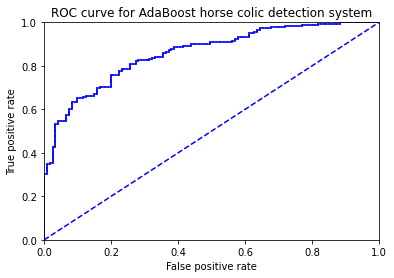

The Area Under the Cruve is:  0.8582969635063604


In [20]:
datArr,labelArr = loadDataSet('../data/AdaBoost/horseColicTraining2.txt')
classifierArray,aggClassEst = adaBoostTrainDS(datArr,labelArr,10)
plotROC(aggClassEst.T,labelArr)

## 基于代价函数的超分类决策控制
- 除了调节分类器阈值之外，我们还有一些其他用于处理非均匀分类代价问题的方法，其中的一种称为代价敏感的学习（cost-sensitive learning）
- 分类算法中，可以引入代价信息。AdaBoost可以基于代价函数调整错误权重向量D，可以选择最小期望代价而不是最大概率的类别作为最后结果，例如在SVM中可以在代价函数中对于把不同类别选择不同参数C

## 处理非均衡问题的数据抽样方法
- 还有一种针对非均衡问题调节分类器的方法，就是对分类器的训练数据进行改造。这可以通过undersampling或者oversampling来处理